In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import importlib
import os
import tqdm
from torchvision import transforms, datasets

import pytorch_ssim
from spinet_utils import *
from arch import get_generator

In [19]:
colum_perm = "normal"
row_perm   = "tv_order"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1

features = 64*64
measures = 333
network  = "autoencoder"

In [20]:
px = int(np.sqrt(features))
py = px
A, row_index, col_index = gen_sensing_matrix(features, measures, colum_perm, row_perm)

In [21]:
original_dataset = datasets.ImageFolder(root="./dataset/test/", transform=transforms.Compose([
        transforms.Resize((px,py)),
        transforms.Grayscale(num_output_channels=1),
]))

testset_coil = datasets.ImageFolder(root="./dataset/test/", transform=transforms.Compose([
        transforms.Resize((px,py)),
        transforms.Grayscale(num_output_channels=1),
        SensingDiferential(A),
        AWGN(30),
        InverseFWHT(row_index, col_index),
]))

In [22]:
targets = [s[0] for s in original_dataset]
data    = [s[0] for s in testset_coil]

test_dataset = TestDatasetFromFolder(data, targets, transforms.ToTensor())
testloader   = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

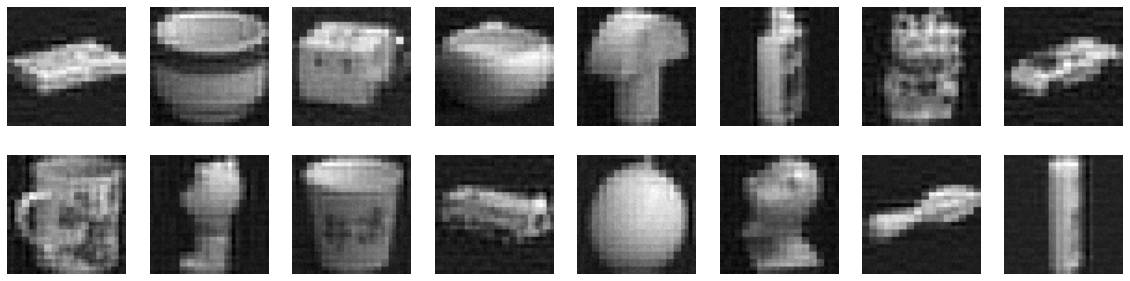

In [23]:
f = plt.figure(figsize=(20,5))
cols = 8
rows = 2
for i in range(cols*rows):
    sp = f.add_subplot(rows,cols,i+1)
    sp.axis('Off')
    plt.imshow(data[i].reshape(px,py),cmap='gray')

In [26]:
out_path = 'training_results/SRF' + '/'
if not os.path.exists(out_path):
    os.makedirs(out_path)
        
with torch.no_grad():
    val_bar = tqdm.notebook.tqdm(testloader)
    valing_results = {'mse': 0, 'psnr': 0, 'ssim': 0}
    val_images = []
    for val_lr, val_hr in val_bar:
        batch_size = val_lr.size(0)
        lr = val_lr.to(DEVICE)
        hr = val_hr.to(DEVICE)
        sr = netG(lr)
        
        batch_mse = ((lr - hr) ** 2).data.mean()
        batch_ssim = pytorch_ssim.ssim(lr, hr).item()
        valing_results['mse']  += batch_mse  
        valing_results['psnr'] += 10 * np.log10((hr.max()**2) / batch_mse)
        valing_results['ssim'] += batch_ssim
       
    valing_results['mse']  /= len(val_bar)
    valing_results['psnr'] /= len(val_bar)
    valing_results['ssim'] /= len(val_bar)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
netG = get_generator(network).to(DEVICE)
netG.load_state_dict(torch.load('model_zoo/autoencoder.pth'))
netG.eval()

print('# generator parameters: {:,}'.format(sum(param.numel() for param in netG.parameters())))

# generator parameters: 194,192


In [32]:
valing_results

{'mse': tensor(0.0116), 'psnr': tensor(18.6699), 'ssim': 0.6656719639897346}